In [60]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Path to saved keypoints - Change to your path to "/content/drive/MyDrive/keypoints" if in google colab

N_CLASS = 26
DATASET_PATH = "keypoints"
MAX_SAMPLES = 0
MODEL_NAME = "alphabet_modelv2.h5"



In [ ]:

# the model output will be 1 to N_CLASS, which maps to A-Z and "nothing, del and space" (25)
LABELS = {}

# Load dataset
X_train, y_train = [], []
X_test, y_test = [], []
labels = sorted(os.listdir(DATASET_PATH))  # Get sorted A-Z labels
labels.pop()
labels.pop()
labels.pop()
print(labels)

for i, label in enumerate(labels):
    keypoints_path = os.path.join(DATASET_PATH, label)
    keypoints = np.load(keypoints_path)  # Load .npy file

    LABELS[i] = label.split(".")[0]

    KX_train, KX_test, Ky_train, Ky_test = train_test_split(keypoints, [i] * len(keypoints), test_size=0.2, random_state=42)

    X_train.extend(KX_train)
    X_test.extend(KX_test)
    y_train.extend(Ky_train)
    y_test.extend(Ky_test)

# Convert lists to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

y_test = to_categorical(y_test, num_classes=N_CLASS)
y_train = to_categorical(y_train, num_classes=N_CLASS)

print(LABELS)
# encode labels (N_CLASS classes) - https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical


# Define simple feedforward model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(42,)),  # 21 keypoints × (x, y)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(N_CLASS, activation='softmax')  # Output layer (N_CLASS classes)
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [38]:

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,  # Adjust as needed
    batch_size=32,
    verbose=1
)

# Save trained model
model.save("alphabet_modelv2.h5")
print("Model training complete and saved!")


Epoch 1/30
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 3s 495us/step - accuracy: 0.6004 - loss: 1.4367 - val_accuracy: 0.6413 - val_loss: 1.2309
Epoch 2/30
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6808 - loss: 1.1202 - val_accuracy: 0.6211 - val_loss: 1.2922
Epoch 3/30
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 2s 471us/step - accuracy: 0.6912 - loss: 1.0771 - val_accuracy: 0.6219 - val_loss: 1.2761
Epoch 4/30
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6904 - loss: 1.0782 - val_accuracy: 0.6207 - val_loss: 1.2522
Epoch 5/30
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step - accuracy: 0.6897 - loss: 1.0792 - val_accuracy: 0.6701 - val_loss: 1.1364
Epoch 6/30
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 2s 468us/step - accuracy: 0.6937 - loss: 1.0666 - val_accuracy: 0.6895 - val_loss: 1.0756
Epoch 7/30
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 3s 485us/step - accuracy: 0.6988 - loss: 1.0445 - val_accuracy: 0.6932 - val_loss: 1.0641
Epoch 8/30
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 3s 498us/step - accuracy: 0.6962 -

Model training complete and saved!


In [39]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("alphabet_modelv2.h5")

# Print model summary to confirm it's loaded
#model.summary()

# Load a sample .npy file for prediction
sample_keypoints = np.load(os.path.join(DATASET_PATH, 'B.npy'))

# Use only the first element of the npy file
sample_keypoints = sample_keypoints[0].reshape((1, -1))

# Make a prediction
prediction = model.predict(sample_keypoints)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[8.8314679e-05 9.7427839e-01 9.6794367e-03 1.2720922e-03 5.8353073e-03
  6.3611404e-04 2.6901532e-06 2.5409679e-05 8.9051615e-04 1.2573319e-05
  3.3957639e-07 4.9387722e-07 3.2247270e-03 1.0968468e-04 1.6931945e-04
  3.8647559e-05 1.4917265e-05 7.5823959e-04 4.9534442e-06 6.8482032e-06
  1.8816232e-03 2.8252760e-05 9.9096296e-04 2.7967366e-05 1.0358875e-05
  1.1889406e-05]]


<Axes: ylabel='accuracy'>

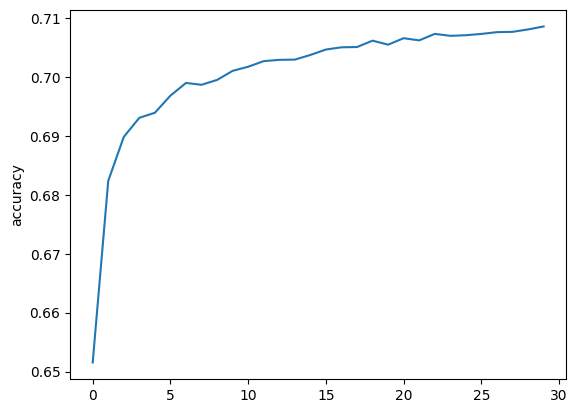

In [40]:
import seaborn as sns

sns.lineplot(data=history.history, x=range(len(history.history['accuracy'])), y='accuracy')

In [41]:
def get_label(output):
    return LABELS.get(output)

def predict_letter(model, keypoints):
    
    """Predicts an ASL letter from extracted keypoints."""
    
    keypoints = np.array(keypoints).reshape(1, -1)  # Ensure correct shape
    prediction = model.predict(keypoints, verbose=False)
    predicted_index = np.argmax(prediction)  # Get index of highest probability
      # Map index to letter
    predicted_letter = get_label(predicted_index)
    return predicted_letter


In [ ]:
import pandas as pd

model = tf.keras.models.load_model(MODEL_NAME)

columns = ["labels"]

columns.extend(list(LABELS.values()))

df = pd.DataFrame(columns=columns)

for i in range(N_CLASS):
    df.loc[len(df)] = ([0] * len(df.columns))

df.labels = list(LABELS.values())
df = df.set_index("labels",drop=True)

print(len(X_test))

for i in range(len(X_test)):
    guess = predict_letter(model, X_test[i])
    correct = get_label(np.argmax(y_test[i]))
    df.loc[guess][correct] += 1

print(df)

/var/folders/j_/kr9vwtx95p910gw4svyxjv8r0000gp/T/ipykernel_32329/3267913937.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[guess][correct] += 1


41238
           A     B    C     D     E     F     G     H     I     J  ...    Q  \
labels                                                             ...        
A       1049     0    3     0     7     0     4     0     0     0  ...    0   
B          0  1224    0     0     0     0     0     0     0     0  ...    0   
C          0     1  909     0     0     0     3     4     0     0  ...    2   
D          0     0    0  1176     0     0     0     0     0     0  ...    0   
E          0     0    0     0  1059     0     1     0     0     0  ...    0   
F          0     1    0     1     0  1493     3     0     0     0  ...    0   
G          0     0    2     0     0     0  1164     3     0     0  ...    0   
H          0     0    0     0     0     0     4  1156     0     3  ...    0   
I          0     1    0     6     0     0     0     0  1040     0  ...    0   
J          1     0    0     0     0     0     0     1    68  1108  ...    0   
K          0     0    0     1     0     0     

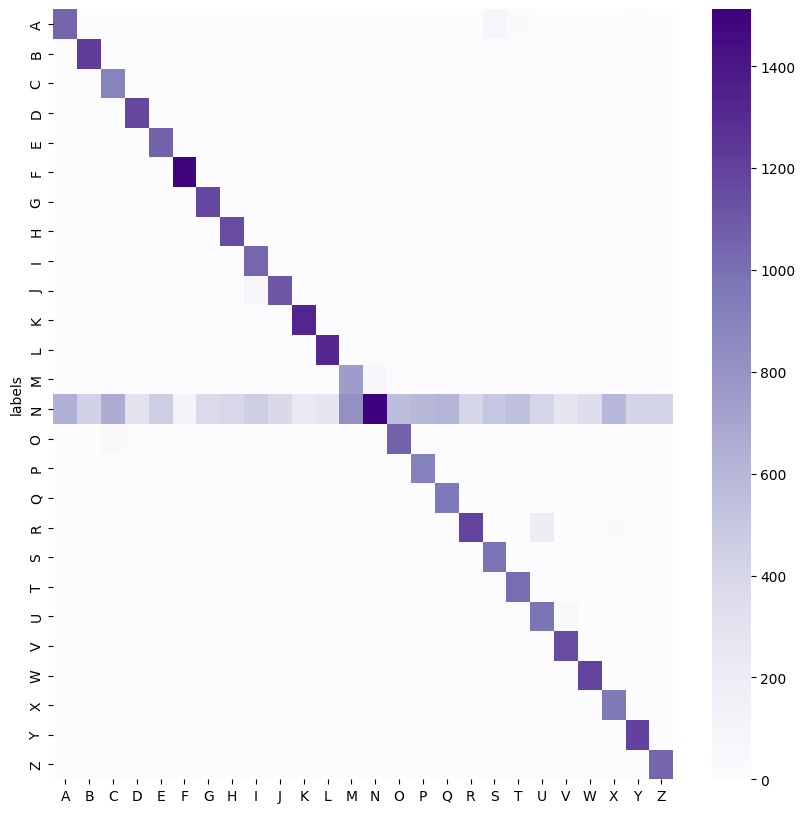

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df, ax=ax, cmap='Purples')
plt.show()


In [21]:
int(df['A'].sum())

1692

In [ ]:
metrics = pd.DataFrame(columns=['Label','Correct','incorrect','accuracy',''])

for label in list(LABELS.values()):
    correct = int(df[label][label])
    incorrect = int(df[label].sum()) - correct
    accuracy = correct / (correct + incorrect) if (correct + incorrect) > 0 else 0
    metrics = pd.concat([metrics, pd.DataFrame([[label, correct, incorrect, accuracy]], columns=['label', 'correct', 'incorrect', 'accuracy'])], ignore_index=True)

print(metrics)

   label correct incorrect  accuracy
0      A    1049       643  0.619976
1      B    1224       438  0.736462
2      C     909       721  0.557669
3      D    1176       350  0.770642
4      E    1059       490  0.683667
5      F    1493       114  0.929060
6      G    1164       405  0.741874
7      H    1156       426  0.730721
8      I    1040       551  0.653677
9      J    1108       393  0.738175
10     K    1329       247  0.843274
11     L    1312       276  0.826196
12     M     746       834  0.472152
13     N    1512        75  0.952741
14     O    1058       570  0.649877
15     P     920       601  0.604865
16     Q     959       632  0.602766
17     R    1188       417  0.740187
18     S     983       639  0.606042
19     T    1014       597  0.629423
20     U     984       621  0.613084
21     V    1157       363  0.761184
22     W    1198       360  0.768935
23     X     956       663  0.590488
24     Y    1202       434  0.734719
25     Z    1049       433  0.707827


/var/folders/j_/kr9vwtx95p910gw4svyxjv8r0000gp/T/ipykernel_32329/814615356.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, pd.DataFrame([[label, correct, incorrect, accuracy]], columns=['label', 'correct', 'incorrect', 'accuracy'])], ignore_index=True)


<Axes: xlabel='label', ylabel='accuracy'>

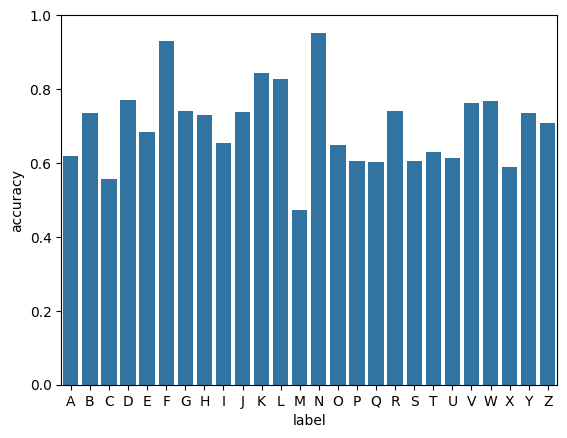

In [59]:
sns.barplot(metrics,x='label',y='accuracy')

In [72]:
path = MODEL_NAME.removesuffix(".h5")
os.makedirs(f"../models/{path}", exist_ok=True)
df.to_json(f"../models/{path}/matrix.json")
metrics.to_json(f"../models/{path}/metrics.json")
hist = pd.DataFrame(history.history).to_json(f"../models/{path}/history.json")


,accuracy,loss,val_accuracy,val_loss
0,0.651532,1.234082,0.641253,1.230850
1,0.682363,1.110618,0.621126,1.292178
2,0.689828,1.079886,0.621854,1.276106
3,0.693067,1.068475,0.620690,1.252243
4,0.693922,1.064003,0.670110,1.136427
5,0.696833,1.056730,0.689485,1.075640
6,0.698979,1.046517,0.693196,1.064066
7,0.698670,1.047611,0.624351,1.355233
8,0.699495,1.046332,0.697633,1.068051
9,0.701035,1.041290,0.642587,1.206779
